**Warning** Work in progress notebook - only for testing purposes only of sunpy and nustar_pysolar

In [12]:
from astropy.io import fits
import astropy.units as u

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
%matplotlib inline
# %matplotlib notebook

import warnings
warnings.simplefilter('ignore')

from pylab import figure, cm
from astropy.coordinates import SkyCoord

import numpy as np

import nustar_pysolar as nustar

import sunpy.map

from scipy import ndimage

dirin=''
infile = 'nu90410111001A06_cl_sunpos.evt'

# Load in the evt
hdulist = fits.open(dirin+infile)
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()


In [13]:
print(hdr["ontime"])

100.9999999403954


In [14]:
import astropy.time
mjdref=hdr['MJDREFI']
tr = ['2018-09-28T18:50:00', '2018-09-28T18:52:00']
tim_ran = astropy.time.Time(tr, format='isot')

print(tim_ran.mjd)
print(mjdref)
at_ref=astropy.time.Time(mjdref,format='mjd')

print(at_ref.iso)
# number of days for time range since ref
print(tim_ran.mjd-mjdref)
# number of seconds for time range since ref
print(tim_ran.unix-at_ref.unix)
print(evtdata['time'][0])

[58389.78472222 58389.78611111]
55197
2010-01-01 00:00:00.000
[3192.78472222 3192.78611111]
[2.7585660e+08 2.7585672e+08]
275856515.00043726


2999.0 1 3000


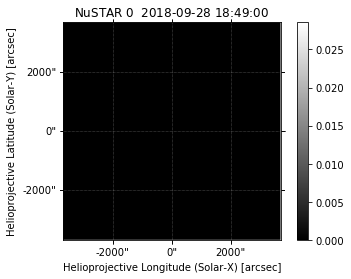

MetaDict([('date-obs', '2018-09-28 18:49:00.157'), ('exptime', 70.0321908915824), ('ontime', 100.9999999403954), ('cdelt1', 2.45810736), ('naxis1', 2999.0), ('crval1', 0.0), ('crpix1', 1499.5), ('cunit1', 'arcsec'), ('ctype1', 'HPLN-TAN'), ('cdelt2', 2.45810736), ('naxis2', 2999.0), ('crval2', 0.0), ('crpix2', 1500.0), ('cunit2', 'arcsec'), ('ctype2', 'HPLT-TAN'), ('pixlunit', 'DN/s'), ('detector', 'NuSTAR'), ('hglt_obs', <Angle 6.83038283 deg>), ('hgln_obs', 0), ('rsun_obs', 957.3856845808288), ('rsun_ref', 695700000.0), ('dsun_obs', <Quantity 1.00192763 AU>), ('naxis', 2)])


In [20]:
# Map the filtered evt, into one corrected for livetime (so units count/s) 
# nustar_map = nustar.map.make_sunpy(cleanevt, hdr,norm_map=True)

# import nustar_pysolar as nustar
import map
import importlib
importlib.reload(map)

nmap = map.make_sunpy(cleanevt, hdr,norm_map=True)
# nmap = nustar_map.make_sunpy(evtdata, hdr,norm_map=True)

nmap.peek()

print(nmap.meta)

275856515.00043726 275856615.9864399
275856540.1566157 275856569.92132163


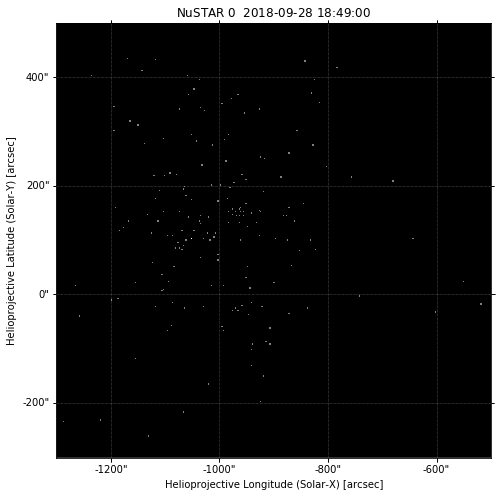

In [206]:
# Filter the evt file
import nustar_filter
import importlib
importlib.reload(nustar_filter)

import astropy.time
tr = ['2018-09-28T18:49:00', '2018-09-28T18:49:30']
tim_ran = astropy.time.Time(tr, format='isot')

cleanevt = nustar_filter.event_filter(evtdata,fpm='A',energy_low=2.5, energy_high=5.0,\
                                      hdr=hdr,\
#                                       xy_range=[-1300,-500,-400,400],\
                                      time_range=tim_ran)

nmap = nustar_map.make_sunpy(cleanevt, hdr,norm_map=True)

print(evtdata['time'].min(),evtdata['time'].max())
print(cleanevt['time'].min(),cleanevt['time'].max())
bl = SkyCoord(-1300*u.arcsec, -300*u.arcsec, frame=nmap.coordinate_frame)
tr = SkyCoord(-500*u.arcsec, 500*u.arcsec, frame=nmap.coordinate_frame)
nms = nmap.submap(bl,tr)
fig = plt.figure(figsize=(9, 8))
nms.plot(colors.Normalize(vmin=1e-3,vmax=1e-1))


# print(len(evtdata),len(cleanevt))

In [94]:
print(nmap.max())

0.028558295471524258


In [95]:
print(nmap.meta['date-obs'][:len(nmap.meta['date-obs'])-4])
print(nmap.meta['ontime'])

2018-09-28 18:48:35
100.9999999403954


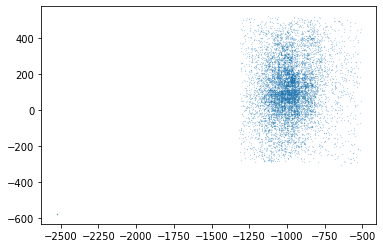

In [124]:
for field in hdr.keys():
    if field.find('TYPE') != -1:
        if hdr[field] == 'X':
            xval = field[5:8]
        if hdr[field] == 'Y':
            yval = field[5:8]
npix=abs(hdr['TLMAX'+xval])
pixsize=hdr['TCDLT'+yval]

xa=pixsize*(evtdata["x"]-npix*0.5)
ya=pixsize*(evtdata["y"]-npix*0.5)
plt.plot(xa,ya,'.',ms=0.2)

In [125]:
print(evtdata['time'][0:10])

[2.75856515e+08 2.75856515e+08 2.75856515e+08 2.75856515e+08
 2.75856515e+08 2.75856515e+08 2.75856515e+08 2.75856515e+08
 2.75856515e+08 2.75856515e+08]


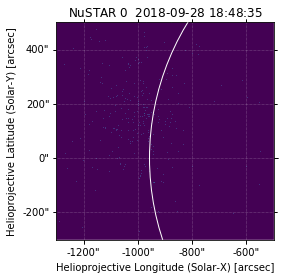

In [96]:
# Immeditate plot to check ok
bl = SkyCoord(-1300*u.arcsec, -300*u.arcsec, frame=nmap.coordinate_frame)
tr = SkyCoord(-500*u.arcsec, 500*u.arcsec, frame=nmap.coordinate_frame)
nms = nmap.submap(bl,tr)

norm = colors.Normalize(vmin=1e-4,vmax=1e-1)
nms.plot_settings['cmap'] = plt.viridis()
nms.plot(norm=norm)
nms.draw_limb()
plt.show()

<Figure size 432x288 with 0 Axes>

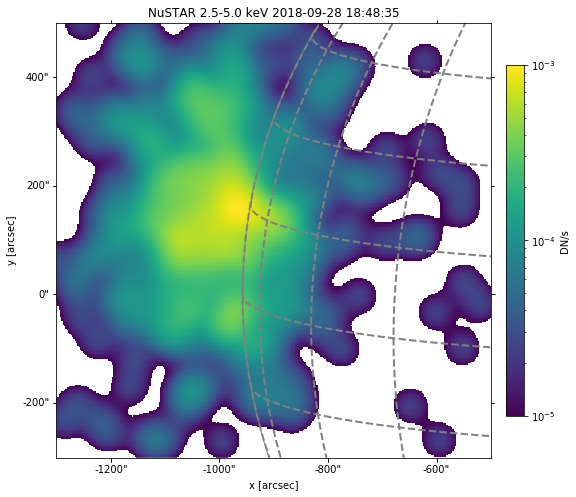

In [97]:
#Apply a guassian blur to the data to bring out the faint feature
dd=ndimage.gaussian_filter(nmap.data, 10, mode='nearest')

# Tidy things up before plotting
dmin=1e-5
dmax=1e-3
dd[dd < dmin]=0
nm=sunpy.map.Map(dd, nmap.meta)

# change the color map
nm.plot_settings['norm'] = colors.LogNorm(vmin=dmin,vmax=dmax)
nm.plot_settings['cmap'] = plt.viridis()

#Zoom into what is happening
bl = SkyCoord(-1300*u.arcsec, -300*u.arcsec, frame=nm.coordinate_frame)
tr = SkyCoord(-500*u.arcsec, 500*u.arcsec, frame=nm.coordinate_frame)
nms = nm.submap(bl,tr)


#Make the figure bigger
fig = plt.figure(figsize=(9, 8))
#Need to pull out the details so can tweak in a few lines
ax = plt.subplot(projection=nms)

# Plot the map
nms.plot()

#Add in the limb
nms.draw_limb(color='grey',linewidth=1,linestyle='dashed',zorder=1)    

# Put on a nice stonyhurst grid
overlay = ax.get_coords_overlay('heliographic_stonyhurst')
lon = overlay[0]
lat = overlay[1]
lon.set_ticks_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)
lon.set_ticklabel_visible(False)
lon.coord_wrap = 180
lon.set_major_formatter('dd')
overlay.grid(color='grey', linewidth=2, linestyle='dashed')

# Tweak the titles and labels
title_obsdate=nmap.meta['date-obs'][:len(nmap.meta['date-obs'])-4]
# title_obsdate='{:.20}'.format('{:%Y-%b-%d %H:%M:%s}'.format(nms.date))
ax.set_title('NuSTAR 2.5-5.0 keV '+ title_obsdate)
ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
# Can just plot the axis labels as integers
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
#Get rid of the default helioprojective grid
ax.grid(False)
# Add a colour bar
plt.colorbar(fraction=0.035, pad=0.03,label='DN/s')
plt.show()